# Combining Active Suggestions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from time import time
from mclearn.experiment import ActiveExperiment, load_results, save_results
from mclearn.tools import log
from sklearn.externals import joblib
from matplotlib.ticker import FuncFormatter
%matplotlib inline
sns.set_style('white')
warnings.filterwarnings('ignore')  # Ignore annoying numpy warnings

## Experiment

Experiment Setup

* 10-fold stratified shuffled split cross validation
* training pool size: 70% of data up to a maximum of 10,000 examples
* test pool size: the remaining examples up to a maximum of 20,000
* use logistic regression with gaussian kernel approximation and L2 loss

To run the experiments, set the constant `RUN_EXPERIMENTS` to True. Note that some datasets are big and can take a long time to finish. For testing purposes, we recommend running the experiment on the `wine` dataset.

In [1]:
# Set this to False to use existing result data stored in the `results` subdirectory
RUN_EXPERIMENTS = False

uci_sets = ['iris', 'wine', 'glass', 'ionosphere', 'magic', 'miniboone',
            'pageblocks', 'pima', 'sonar', 'vehicle', 'wpbc'] 
datasets =  sorted(uci_sets + ['sdss'])

# For testing purposes, uncomment the following line to run
# the experiment with only the wine dataset
# datasets = uci_sets = ['wine']

In [12]:
methods_al =  ['baseline', 'margin', 'w-margin', 'confidence',
            'w-confidence', 'entropy', 'w-entropy',
            'qbb-margin', 'qbb-kl']
methods_bandits = ['thompson', 'ocucb', 'klucb', 'exp++',]
methods_rank = ['borda', 'geometric', 'schulze']
methods_no_passive = methods_al + methods_bandits + methods_rank
methods = ['passive'] + methods_no_passive
measures = ['f1', 'accuracy', 'mpba']

In [4]:
def run_expt(X, y, dataset, methods, scale=True):
    log(dataset, end='')
    for method in methods:
        log('.', end='')
        expt = ActiveExperiment(X, y, dataset, method, scale, n_splits=10, n_jobs=10)
        expt.run_policies()
    
    expt = ActiveExperiment(X, y, dataset, None, scale)
    expt.run_asymptote()
    log('')

In [5]:
if RUN_EXPERIMENTS:
    for dataset in ['glass']:
        data_path = os.path.join('data', dataset + '.csv')
        data = pd.read_csv(data_path)
        X, y = data.iloc[:, 1:], data['target']
        run_expt(X, y, dataset, methods)

    if 'sdss' in datasets:
        data_path = os.path.join('data', 'sdss.h5')
        data = pd.read_hdf(data_path, 'sdss')
        class_idx = data.columns.get_loc('class')
        X, y = data.iloc[:, (class_idx+1):], data['class']
        run_expt(X, y, 'sdss', methods, False)

In [7]:
if RUN_EXPERIMENTS:
    for (i, dataset) in enumerate(datasets):
        maximum = {}
        for measure in measures:
            asymptote_measure = 'asymptote_' + measure
            max_measure = 'max_' + measure
            results = {}
            for method in methods:
                results[method] = load_results(dataset, method, measure, True)
            results['asymptote'] = load_results(dataset, 'asymptote', asymptote_measure, True)
            maximum[max_measure] = results['asymptote']
            for method in methods:
                maximum[max_measure] = max(maximum[max_measure], max(results[method]))
        save_results(dataset, 'max', maximum)

### No passive arm

This is a small experiment to see what happens if we remove the passive arm (that simply picks a random candidate at each time step) as an expert.

In [4]:
def run_expt(X, y, dataset, methods, scale=True):
    log(dataset, end='')
    for method in methods:
        log('.', end='')
        expt = ActiveExperiment(X, y, dataset, method, scale=scale, passive=False)
        expt.run_policies()

In [5]:
no_passive_methods =  ['thompson', 'ocucb', 'klucb',
                       'exp++', 'borda', 'geometric', 'schulze']

In [6]:
if RUN_EXPERIMENTS:
    for dataset in uci_sets:
        data_path = os.path.join('data', dataset + '.csv')
        data = pd.read_csv(data_path)
        X, y = data.iloc[:, 1:], data['target']
        run_expt(X, y, dataset, no_passive_methods)

    if 'sdss' in datasets:
        data_path = os.path.join('data', 'sdss.h5')
        data = pd.read_hdf(data_path, 'sdss')
        class_idx = data.columns.get_loc('class')
        X, y = data.iloc[:, (class_idx+1):], data['class']
        run_expt(X, y, 'sdss', no_passive_methods, False)

## Results

In [5]:
def calculate_strength(asymptote, passive, policy):
    deficiency = np.sum(asymptote - policy, axis=1) / np.sum(asymptote - passive, axis=1)
    strength = 1 - deficiency
    return strength

In [6]:
titles = {
    'f1': 'F1',
    'accuracy': 'Accuracy',
    'mpba': 'MPBA'
}

In [32]:
def plot_mpba_strength(measure='mpba', data='small'):
    fig = plt.figure(figsize=(15, 20))
    fig.subplots_adjust(hspace=.6)
    small_datasets = ['glass', 'ionosphere', 'iris', 'sonar', 'wine', 'wpbc']
    large_datasets = ['magic', 'miniboone', 'pageblocks', 'pima', 'sdss', 'vehicle']
    datasets = small_datasets if data == 'small' else large_datasets
    
    for (i, dataset) in enumerate(datasets):
        results = {}
        for method in methods:
            results[method] = load_results(dataset, method, measure, mean=False)
        results['max'] = load_results(dataset, 'max', 'max_' + measure, False)
        strength_dict = {}
        for method in methods_no_passive:
            s = calculate_strength(results['max'], results['passive'], results[method])
            strength_dict[method] = s
        strength_df = pd.DataFrame(strength_dict)
        sorted_cols = (-strength_df.median()).sort_values().index
        strength_df = strength_df[sorted_cols]

        ax = fig.add_subplot(6, 2, i + 1)
        strength_df.index.name = 'trial'
        strength_df = strength_df.reset_index()
        strength_df = strength_df.melt(id_vars=['trial'], value_vars=methods_no_passive)
        strength_df.loc[strength_df['variable'].isin(methods_al), 'type'] = 'single'
        strength_df.loc[strength_df['variable'].isin(methods_bandits), 'type'] = 'bandit'
        strength_df.loc[strength_df['variable'].isin(methods_rank), 'type'] = 'rank'
        strength_df.loc[strength_df['variable'] == 'baseline', 'variable'] = 'explore'
        sorted_cols = list(sorted_cols)
        sorted_cols[sorted_cols.index('baseline')] = 'explore'
        # We could use hue here, but I think there is a bug in seaborn that squishes
        # the boxplot
        
        palette_map = {
            **{m: sns.color_palette()[0] for m in methods_al},
            **{m: sns.color_palette()[2] for m in methods_bandits + ['explore']},
            **{m: sns.color_palette()[1] for m in methods_rank},
        }
        sns.boxplot(data=strength_df, x='variable', y='value', order=sorted_cols,
                    width=0.4, linewidth=1, palette=palette_map, fliersize=3)
        ax.set_title(dataset)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, rotation_mode='anchor', ha='right')
        ax.xaxis.set_visible(True)
        ax.set_ylabel(titles[measure] + ' Strength')
        ax.set_xlabel('')
        ax.axhline(linewidth=1)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
        
        # set bar width
        new_width = 0.5
        for bar in ax.patches:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + new_width / 2.

            bar.set_x(centre - new_width / 2.)
            bar.set_width(new_width)
            
#     fig.savefig('figures/strengths-{}-{}.pdf'.format(measure, data), bbox_inches='tight')

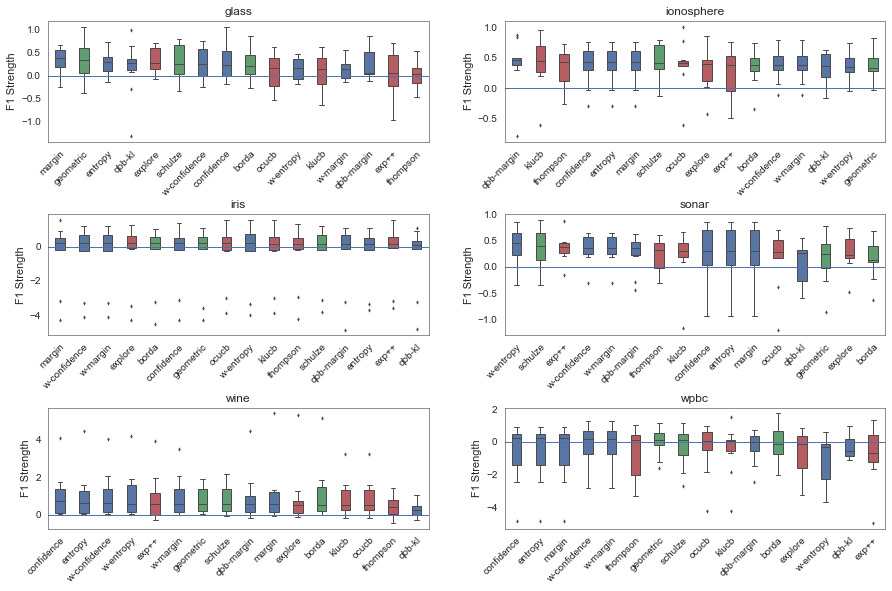

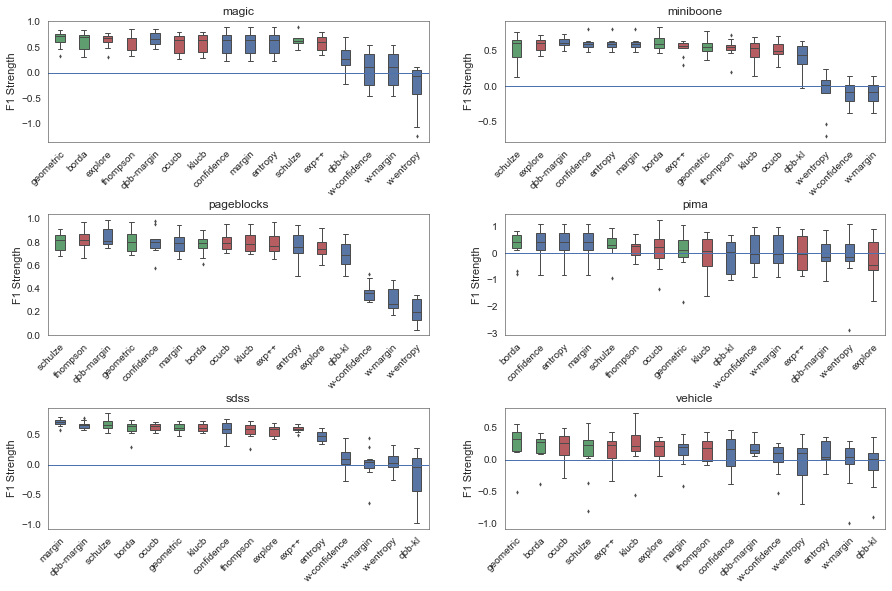

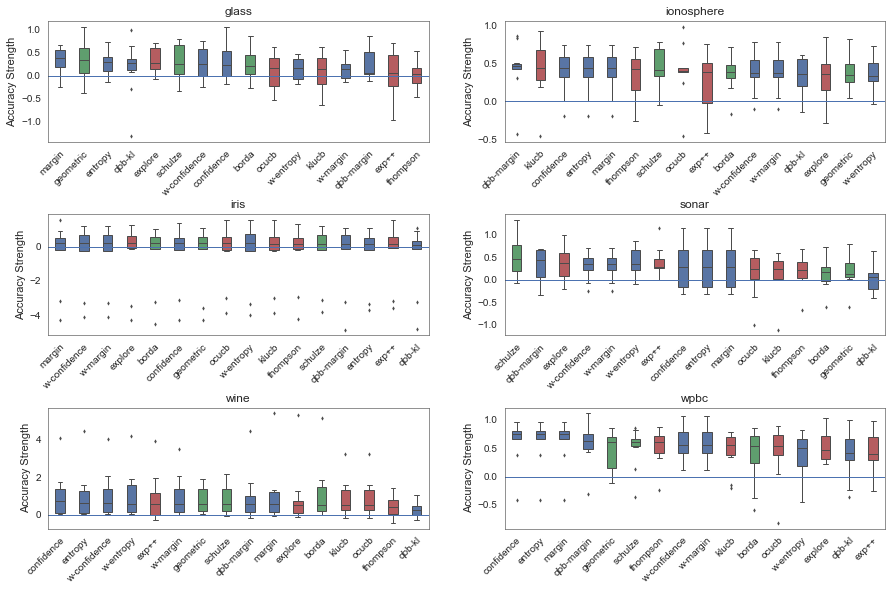

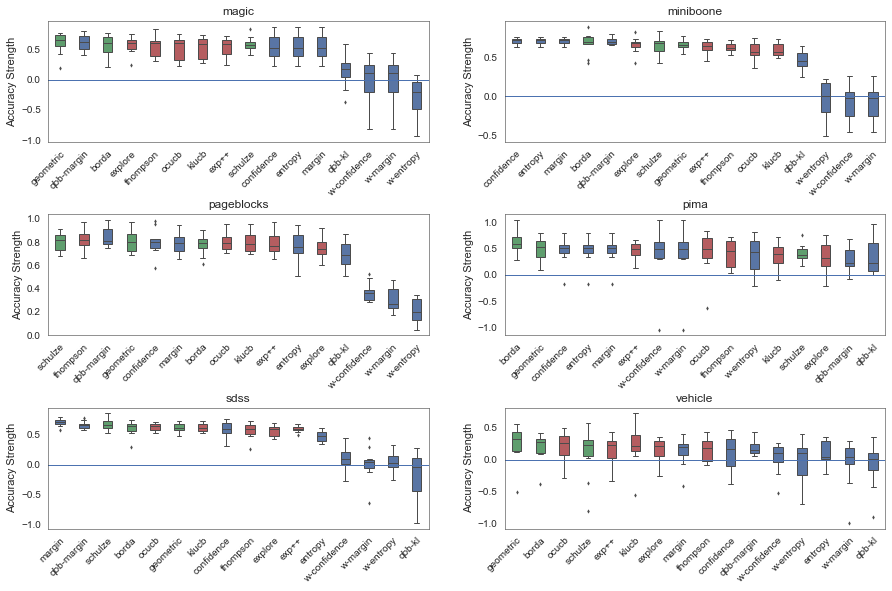

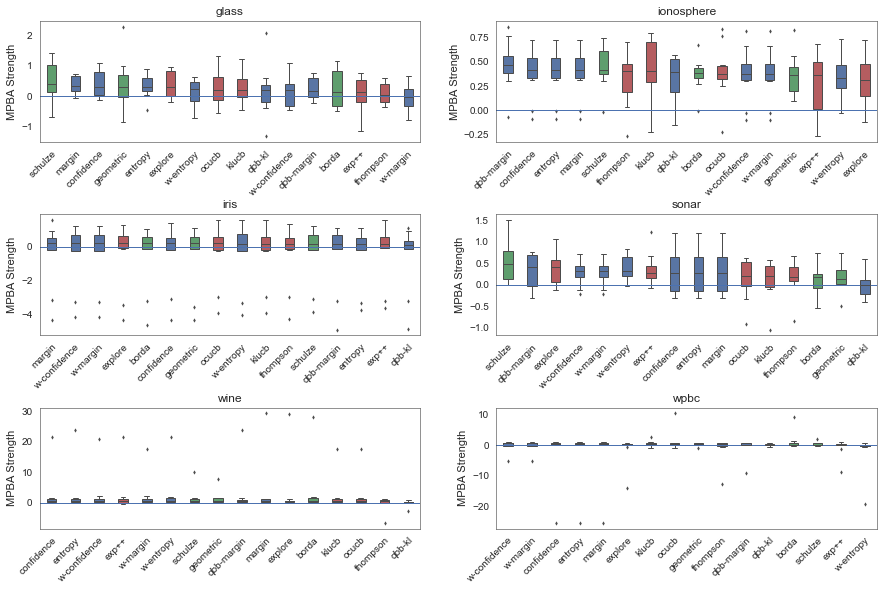

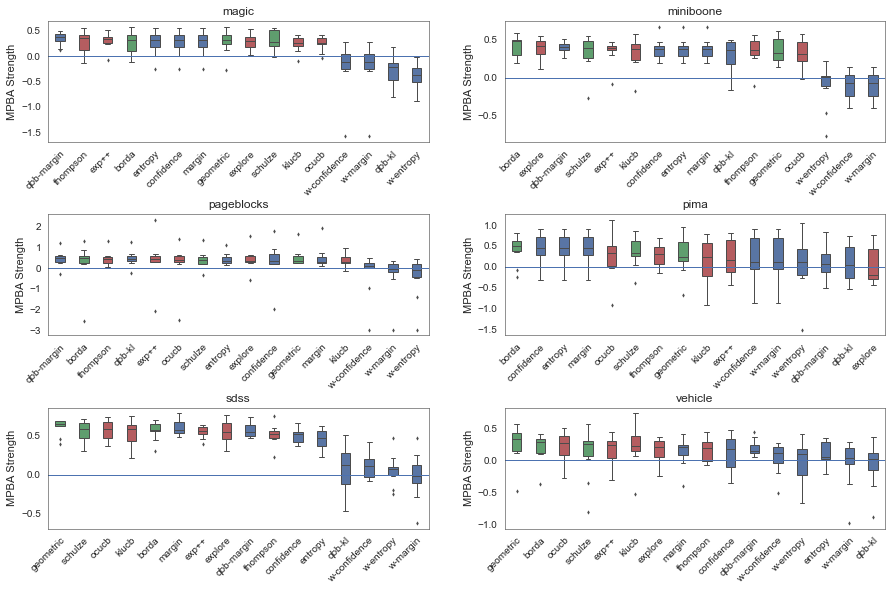

In [33]:
plot_mpba_strength('f1', 'small')
plot_mpba_strength('f1', 'large')
plot_mpba_strength('accuracy', 'small')
plot_mpba_strength('accuracy', 'large')
plot_mpba_strength('mpba', 'small')
plot_mpba_strength('mpba', 'large')

In [7]:
def plot_learning_curves(measure, data):
    small_datasets = ['glass', 'ionosphere', 'iris', 'sonar', 'wine', 'wpbc']
    large_datasets = ['magic', 'miniboone', 'pageblocks', 'pima', 'sdss', 'vehicle']
    datasets = small_datasets if data == 'small' else large_datasets
    
    selected_methods = ['passive', 'confidence', 'borda', 'exp++']
    format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
    fig = plt.figure(figsize=(15, 20))
    for (i, dataset) in enumerate(datasets):
        initial_n = 10
        
        learning_curves = {}
        for method in selected_methods:
            learning_curves[method] = load_results(dataset, method, measure, True)
        maximum = load_results(dataset, 'max', 'max_{}'.format(measure), False)
        sample_size = learning_curves['passive'].shape[0] + 9

        ax = fig.add_subplot(4, 3, i + 1)
        for method in selected_methods:
            xticks = np.arange(initial_n, initial_n + len(learning_curves[method]))
            ax.plot(xticks, learning_curves[method], label=method, linewidth=1)

        ax.legend(loc='lower right', frameon=True)
        ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
        ax.set_title(dataset)
        ax.tick_params(top='off')
        ax.set_ylabel(titles[measure])

        ax.plot([initial_n, sample_size], [maximum, maximum], ls='--', color='#377eb8')
        ax.set_xlim(initial_n, sample_size)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
#     fig.savefig('figures/learning_curves-{}-{}.pdf'.format(measure, data), bbox_inches='tight')

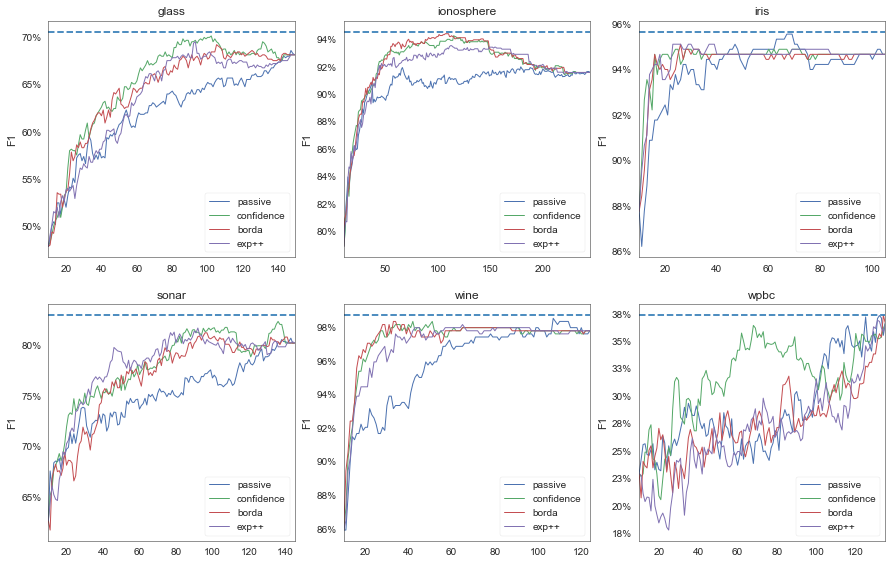

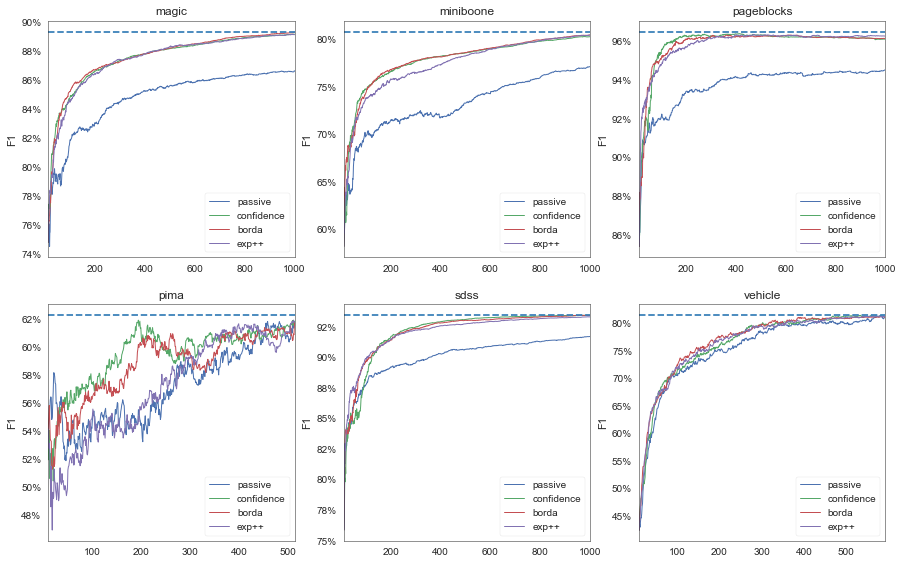

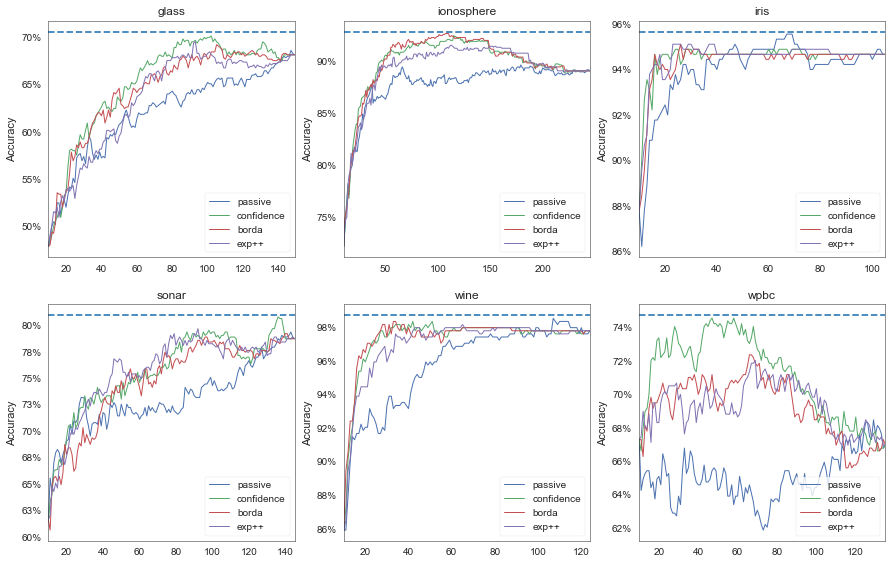

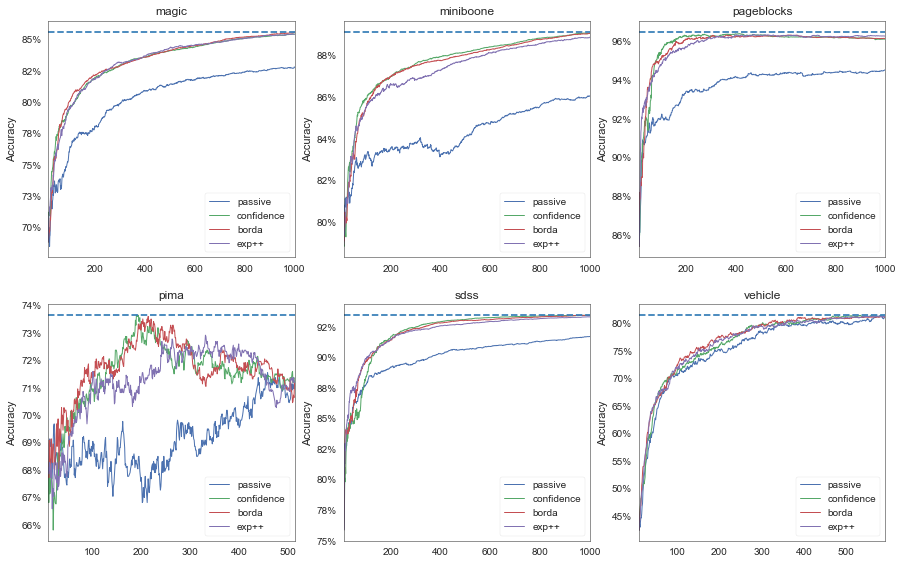

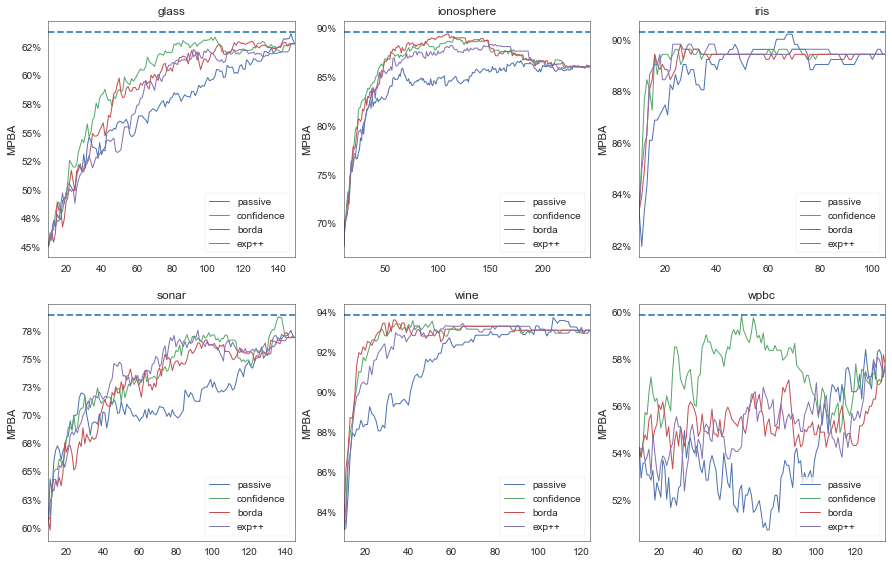

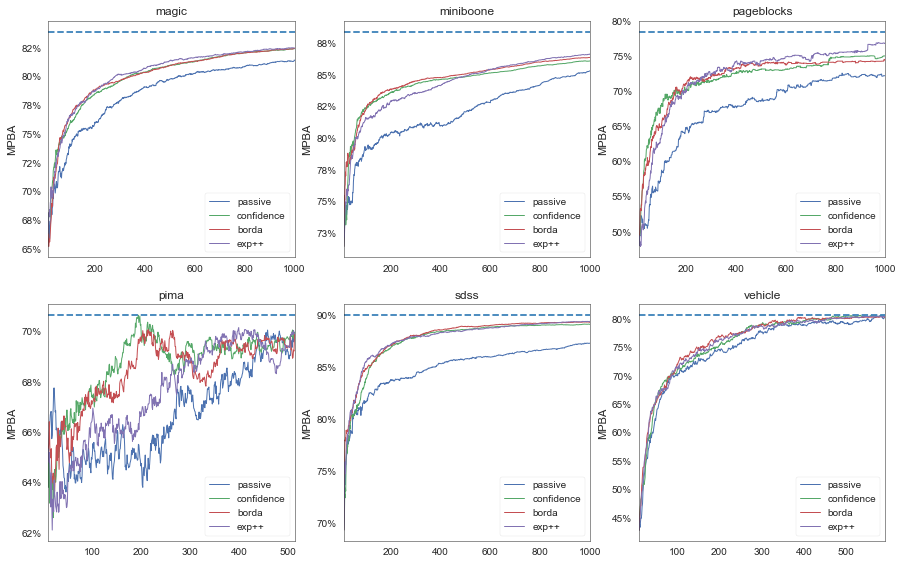

In [8]:
plot_learning_curves('f1', 'small')
plot_learning_curves('f1', 'large')
plot_learning_curves('accuracy', 'small')
plot_learning_curves('accuracy', 'large')
plot_learning_curves('mpba', 'small')
plot_learning_curves('mpba', 'large')

In [7]:
colors = {'passive': '#e6ab02',
          'entropy': '#e7298a',
          'margin': '#d95f02',
          'qbb-margin': '#1b9e77',
          'qbb-kl': '#66a61e',
          'passive': '#7570b3',
          'confidence': '#a6761d'}

In [21]:
def plot_selections(method, data='large'):
    small_datasets = ['glass', 'ionosphere', 'iris', 'sonar', 'wine', 'wpbc']
    large_datasets = ['magic', 'miniboone', 'pageblocks', 'pima', 'sdss', 'vehicle']
    datasets = small_datasets if data == 'small' else large_datasets
    fig = plt.figure(figsize=(15, 20))
    
    for (i, dataset) in enumerate(datasets):
        ax = fig.add_subplot(4, 3, i + 1)
        result = load_results(dataset, method)
        arms = ['passive', 'margin', 'confidence', 'entropy', 'qbb-margin', 'qbb-kl']
        total_n = sum(result['T'][0][-1])
        sample_sizes = np.arange(10, total_n + 10)
        trials = np.arange(1, total_n + 1)
        props = np.mean(result['T'], axis=0)[1:] / np.repeat(trials.reshape(-1, 1), 6, axis=1)
        df = pd.DataFrame(props, columns=arms)

        ordered_labels = df.iloc[-1].sort_values(ascending=False).index
        for label in ordered_labels:
            curve = df[label]
            inital_n = sample_sizes[0] - 1
            n_selections = sample_sizes - inital_n
            ax.plot(sample_sizes, curve, label=label, color=colors[label],
                ls='-', linewidth=1)

        ax.set_xlabel('Training Size')
        ax.set_ylabel('Frequency of Selections')
        ax.legend(loc='lower right', frameon=True)
        ax.set_title(dataset)
        ax.set_ylim((0, 0.3))
        ax.set_xlim((10, total_n + 10))
        format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
        ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
#         fig.savefig('figures/selection-{}-{}.pdf'.format(method, data), bbox_inches='tight')

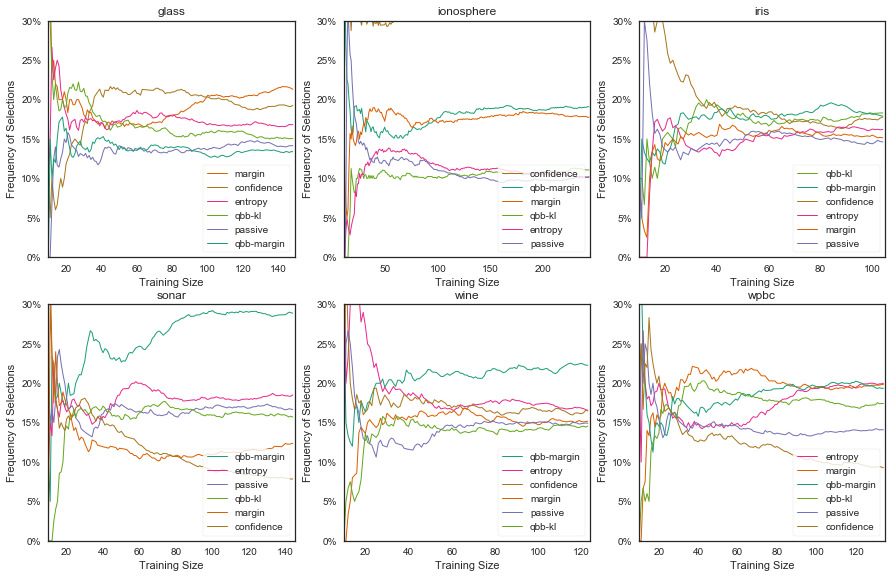

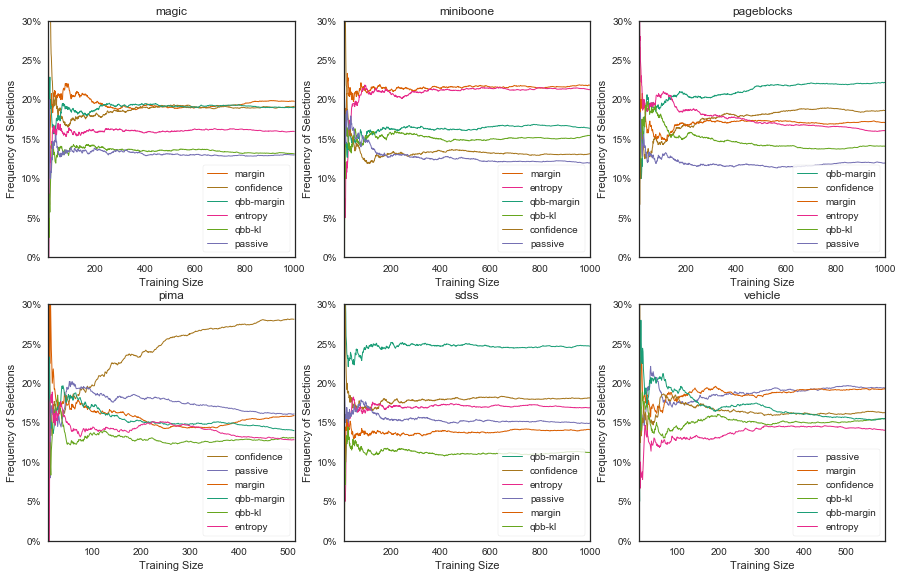

In [22]:
plot_selections('thompson', 'small')
plot_selections('thompson', 'large')

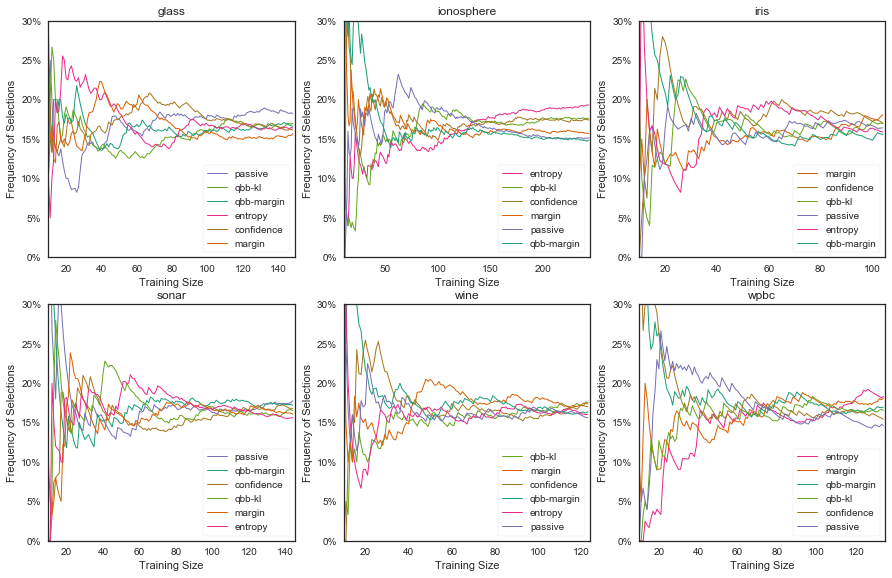

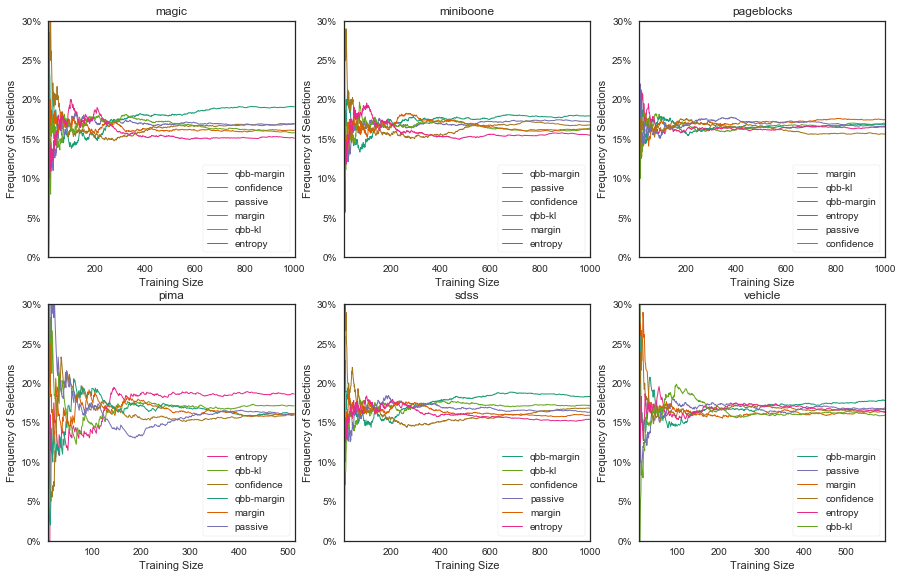

In [23]:
plot_selections('exp++', 'small')
plot_selections('exp++', 'large')

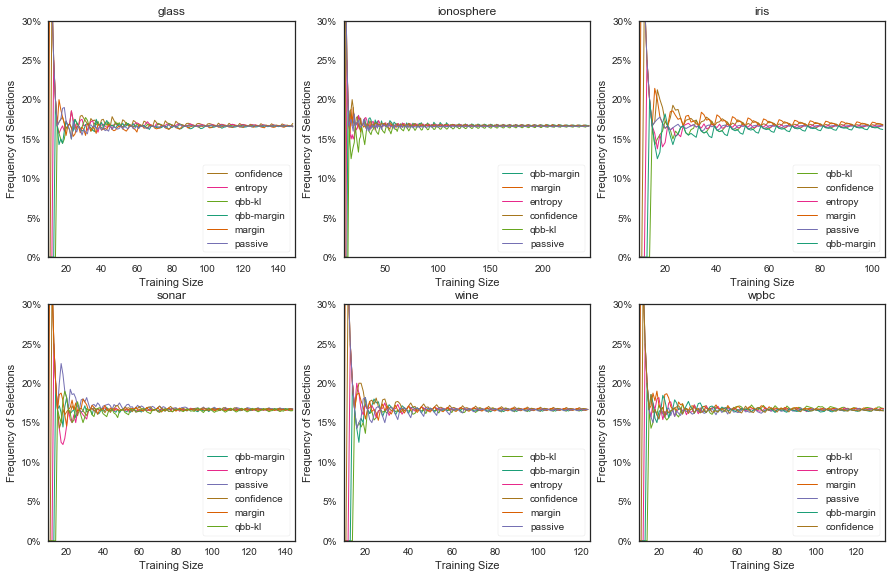

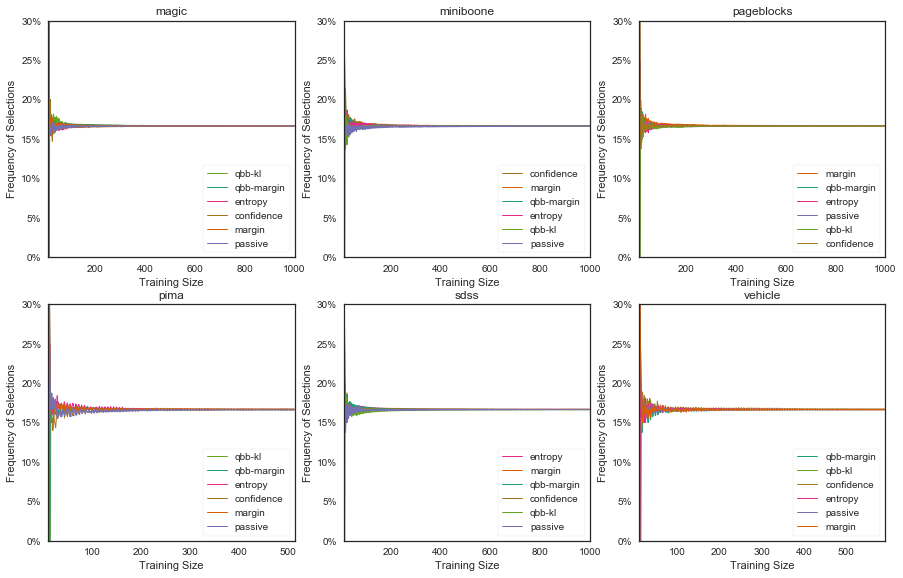

In [24]:
plot_selections('ocucb', 'small')
plot_selections('ocucb', 'large')

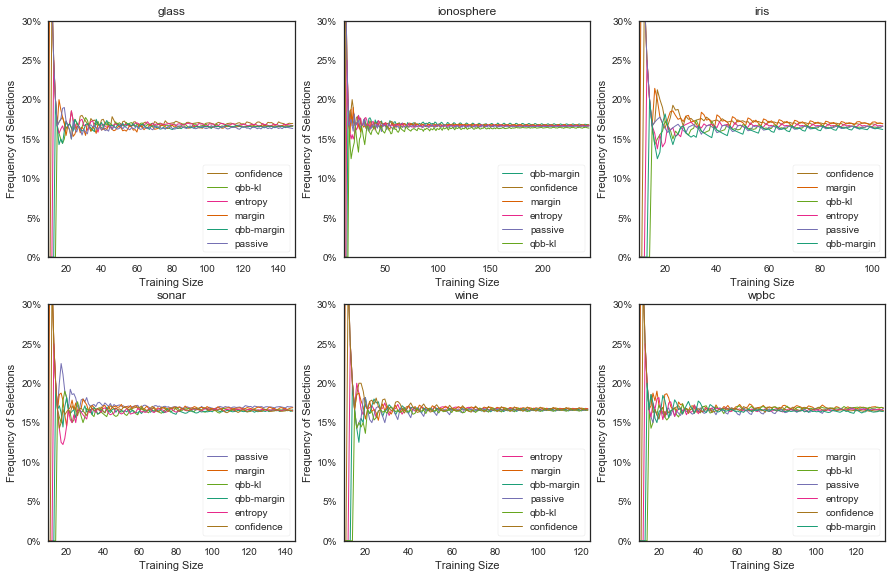

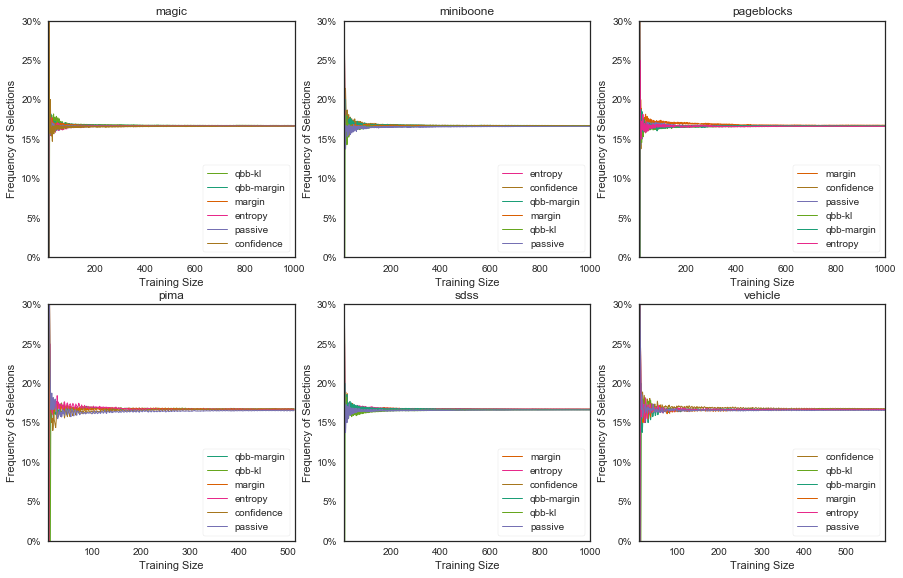

In [25]:
plot_selections('klucb', 'small')
plot_selections('klucb', 'large')

## Visualisation of Strength

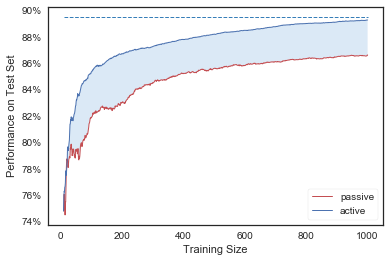

In [10]:
passive = load_results('magic', 'passive', 'f1', True)
borda = load_results('magic', 'borda', 'f1', True)
sample_size = passive.shape[0]

format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
xticks = np.arange(10, 10 + sample_size)
ax.plot(xticks, passive, label='passive', color=sns.color_palette()[2], linewidth=1)
ax.plot(xticks, borda, label='active', color=sns.color_palette()[0], linewidth=1)
ax.fill_between(xticks, passive, borda, facecolor=sns.color_palette("Blues")[0])
ax.plot([10, 10 + sample_size], [0.895, 0.895], ls='--', linewidth=1, color='#377eb8')
ax.legend(loc='lower right', frameon=True)
ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
ax.set_ylabel('Performance on Test Set')
ax.set_xlabel('Training Size')
#fig.savefig('figures/strength.pdf', bbox_inches='tight')